In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import random
import math
from scipy.optimize import minimize

In [3]:
%matplotlib inline

In [4]:
nofactivities=3
noffxdressource=1
#Q=np.array([[2.,1.,-0.5],[1.,4.,0.75],[-0.5,0.75,3.]])
#L=np.array([[0.8,0.,0.],[0.1,0.9,0.],[-0.1,-0.5,0.6]])
L=np.array([[2,0.,0.],[1,4,0.],[0.1,0.1,3]])
Q=np.dot(np.array(L),np.transpose(np.array(L)))
c=np.array([1.5,5,2])
#p=[59,42,62]    #prices for each activity
#p=[59,91,62]    #prices for each activity
pcenter=[340,420,410] #center of prices for each activity
prange=[34,42,41] #range by which individual prices may deviate from center
nstart=10 #number of farms in the start sample
nmax=150 #number of farms in the biggest sample
stepsize=20 #increment by which number of farms increases in each step
nruns= 100 #number of runs for each stepsize
#mu_b= 25 #mean size of farmland b
mu_b= 100 #mean size of farmland b
stdev_b=20  #standard deviation of farmland b
print(Q)


[[ 4.    2.    0.2 ]
 [ 2.   17.    0.5 ]
 [ 0.2   0.5   9.02]]


In [265]:
#create samples of the respective size
counter, ssize, run, landsize = [],[],[],[]
samplesize=nstart
farmcounter=0
while samplesize <= nmax:
    currentrun=0
    while currentrun < nruns:
        b_raw=np.random.normal(mu_b, stdev_b, samplesize)
        for i in b_raw: 
            counter.append(farmcounter)
            ssize.append(samplesize)
            run.append(currentrun)
            landsize.append(round(i, 2))
            farmcounter+=1
        currentrun+=1
    samplesize+=stepsize
randomsamples={'fid':counter,'samplesize':ssize, 'run':run,'landsize':landsize }
    

In [266]:
randomsamples_df=pd.DataFrame(randomsamples)

In [267]:
#verify that smallest landsize is still >0
randomsamples_df['landsize'].min()

13.75

In [268]:
#add activity prices for each farm
prices={'p1':[],'p2':[],'p3':[],'fid':[]}
for f in range(len(randomsamples_df)):
    for i in range(nofactivities):
        prices[f'p{i+1}'].append(pcenter[i]+random.randint(-prange[i],prange[i]))
    prices['fid'].append(f)
prices_df=pd.DataFrame(prices)

In [269]:
randomsamples_df=pd.merge(randomsamples_df, prices_df, on='fid')
randomsamples_df.head()

,fid,samplesize,run,landsize,p1,p2,p3
0,0,10,0,111.37,340,441,434
1,1,10,0,121.25,323,415,397
2,2,10,0,123.57,358,435,421
3,3,10,0,87.00,356,462,421
4,4,10,0,118.21,356,408,427


In [270]:
"""
four types of variables exist:
- x activity levels --> dimension 1xI
- y shadow prices of fixed resources --> dimension 1xJ
- zp slack variables related to the primal constraint --> dimension 1xI
- zd slack variables related to the dual constraint --> dimension 1xJ


all are captured in the vector X which therefore has dimension 1x(I*2+J*2)

in this example with three crop types and one constraint (land) I=3 and J=1:
X is of dimension 1x8:
- x1-x3=X[0]-X[2]
- y1=[X3]
- zp1-zp3=X[4]-X[6]
- zd1=X[7]
""" 

def objective(X):
    CSC=0
    for i in range(nofactivities+noffxdressource):
        CSC+=X[i]*X[i+4]
    CSC+=X[3]*X[7]
    return CSC

def constraint1(X):
    must_be_zero1=0
    for i in range(nofactivities):
        part1= X[3]+c[i]
        part2= 0
        for j in range(nofactivities):
            part2+=Q[i][j]*X[j]
        must_be_zero1+= (p[i]-(part1+part2-X[i+4]))**2
    return must_be_zero1
def constraint2(X):
    land=0
    for i in range(nofactivities):
        land+=X[i]
    return b_farm-(land+X[7])

    

In [271]:
X0=[1,1,1,1,0,0,0,0]    #set initial values
bndx=(0.0, 1000000.0)
bndy=(0.0, 1000000.0)
bndz=(0.0, 1000000.0)
bnds=(bndx, bndx, bndx, bndy, bndz, bndz, bndz, bndz)
con1 = {'type': 'eq', 'fun':constraint1}
con2 = {'type': 'eq', 'fun':constraint2}
cons = [con1, con2]

results={"run":[],"samplesize":[],"fid":[],"x1":[],"x2":[],"x3":[],"y":[],"zp1":[],"zp2":[],"zp3":[],"zd1":[],"b":[],"p1":[],"p2":[],"p3":[]}
for f in range(len(randomsamples_df)):
    b_farm=float(randomsamples_df[randomsamples_df['fid']==f]['landsize'])
    p=[]
    for i in range(nofactivities):
        p.append(int(randomsamples_df[randomsamples_df['fid']==f][f'p{i+1}']))
    sol= minimize(objective, X0, method='SLSQP',\
                 bounds=bnds, constraints=cons)
    results["run"].append(int(randomsamples_df[randomsamples_df['fid']==f]['run']))
    results["samplesize"].append(int(randomsamples_df[randomsamples_df['fid']==f]['samplesize']))
    results["fid"].append(f)
    results["x1"].append(sol.x[0])
    results["x2"].append(sol.x[1])
    results["x3"].append(sol.x[2])
    results["y"].append(sol.x[3])
    results["zp1"].append(sol.x[4])
    results["zp2"].append(sol.x[5])
    results["zp3"].append(sol.x[6])
    results["zd1"].append(sol.x[7])
    results["b"].append(b_farm)
    results["p1"].append(p[0])
    results["p2"].append(p[1])
    results["p3"].append(p[2])

In [272]:
results_df=pd.DataFrame(results)

In [273]:
#Q_est=np.array([[3.59, 1.95, 0.51],[1.95,16.72, 0.72],[0.51, 0.72, 7.8]])
#c_est=[4.41, 4.16, 8.15]
testfarm=results_df[results_df['fid']==3]
float(testfarm['y'])+c[1]+Q[1][0]*float(testfarm['x1'])+Q[1][1]*float(testfarm['x2'])+Q[1][2]*float(testfarm['x3'])


461.9997670090224

In [274]:
results_df.head()

,run,samplesize,fid,x1,x2,x3,y,zp1,zp2,zp3,zd1,b,p1,p2,p3
0,0,10,0,59.276985,13.634485,38.458530,66.431357,0.000000e+00,0.000000e+00,0.000000e+00,3.275304e-13,111.37,340,441,434
1,0,10,1,67.393817,14.090566,39.765617,15.789844,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,121.25,323,415,397
2,0,10,2,70.378158,13.489776,39.702066,40.066613,2.711742e-11,6.159569e-12,1.673472e-11,0.000000e+00,123.57,358,435,421
3,0,10,3,45.607083,12.333110,29.059806,141.592821,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,87.00,356,462,421
4,0,10,4,67.648770,11.471389,39.089841,53.143829,0.000000e+00,0.000000e+00,0.000000e+00,3.042642e-13,118.21,356,408,427


In [9]:
results_df[results_df['y']<0.1]['samplesize'].value_counts()

150    847
130    784
110    617
90     543
70     434
50     283
30     187
10      50
Name: samplesize, dtype: int64

In [277]:
#save samples to excel to prevent time consuming recalculation if downstream changes are made
results_df.to_excel('samples before error.xlsx',index=False)

In [57]:
results_df=pd.read_excel('samples before error.xlsx')

In [58]:
"""
Add deviation from activity levels x and from fixed input prices y:
-the difference between "true" activity levels and observed activity levels is h:
    -h1 = x1 - x1_obs
    -h2 = x2 - x2_obs
    -h3 = x3 - x3_obs
-the difference between "true" fixed input prices and observed fixed input prices:
    -u  =  y - y_obs
    
Error terms h and u are randomly drawn from a standard normal distribution
"""
mu_h, mu_u = 0, 0 #mean of error term h and u, respectively
#stdev_h, stdev_u = 1., 1. #standard deviation of error term h and u, respectively
perc_stdev = 5.  #standard deviation of error terms h and u as percentage of mean
h={'h1':[], 'h2':[], 'h3':[]}
u={'u':[]}
#should error level depend on mean of the levels of the respective activity?
#if yes, stdev_h is multiplied by the ratio of the mean of the respective activity and 
#the mean of the activity that has the biggest mean
weight_on=True #weight stdev, otherwise set to False
means=[]
for i in h.keys(): means.append(float(results_df[f'x{i[1]}'].mean()))
for j in u.keys(): means.append(float(results_df['y'].mean()))
#weight={'h1':1, 'h2':1, 'h3':1}
stdev={'h1':1, 'h2':1, 'h3':1, 'u':1}
if weight_on:
#    for i,j in enumerate(h.keys()): weight[j]=activity_means[i]/max(activity_means)               
     for i,j in enumerate(stdev.keys()): stdev[j]=means[i]*perc_stdev*0.01                                               
for i in h.keys():
#    h[i]=list(np.random.normal(mu_h, stdev_h*weight[i], len(results_df)))
     h[i]=list(np.random.normal(mu_h, stdev[i], len(results_df)))

for i,j in enumerate(u.keys()):
    u[j]=list(np.random.normal(mu_u, stdev[j], len(results_df)))
h['fid']=list(range(len(results_df)))
u['fid']=list(range(len(results_df)))
df_h=pd.DataFrame(h)
df_u=pd.DataFrame(u)

In [59]:
mu_h, mu_u = 0, 0 #mean of error term h and u, respectively
stdev_h, stdev_u = 1., 1. #standard deviation of error term h and u, respectively
perc_stdev = 10.  #standard deviation of error terms h and u as percentage of mean
h={'h1':[], 'h2':[], 'h3':[]}
u={'u':[]}
#should error level depend on mean of the levels of the respective activity?
#if yes, stdev_h is multiplied by the ratio of the mean of the respective activity and 
#the mean of the activity that has the biggest mean
weight_on=True #weight stdev, otherwise set to False
means=[]
for i in h.keys(): means.append(float(results_df[f'x{i[1]}'].mean()))
weight={'h1':1, 'h2':1, 'h3':1}

if weight_on:
    for i,j in enumerate(h.keys()): weight[j]=activity_means[i]/max(activity_means)               
                                              
for i in h.keys():
    h[i]=list(np.random.normal(mu_h, stdev_h*weight[i], len(results_df)))


for i,j in enumerate(u.keys()):
    u[j]=list(np.random.normal(mu_u, stdev[j], len(results_df)))
h['fid']=list(range(len(results_df)))
u['fid']=list(range(len(results_df)))
df_h=pd.DataFrame(h)
df_u=pd.DataFrame(u)

In [60]:
results_df=pd.merge(pd.merge(results_df, df_h, on='fid'),df_u, on='fid')

In [61]:
def create_obs(true_value,error):
    if true_value>0 and true_value-error>0:
        return true_value-error
    else:
        return 0

In [62]:
results_df['x1_obs']=results_df.apply(lambda x: create_obs(x.x1, x.h1), axis=1)
results_df['x2_obs']=results_df.apply(lambda x: create_obs(x.x2, x.h2), axis=1)
results_df['x3_obs']=results_df.apply(lambda x: create_obs(x.x3, x.h3), axis=1)
results_df['y_obs']=results_df.apply(lambda x: create_obs(x.y, x.u), axis=1)

In [63]:
len(results_df[(results_df['x3_obs']==0)&(results_df['x3']>0.01)])

0

In [64]:
results_df.head()

,run,samplesize,fid,x1,x2,x3,y,zp1,zp2,zp3,...,p2,p3,h1,h2,h3,u,x1_obs,x2_obs,x3_obs,y_obs
0,0,10,0,59.276985,13.634485,38.458530,66.431357,0.000000e+00,0.000000e+00,0.000000e+00,...,441,434,0.380871,-0.064164,-0.557521,-1.960662,58.896113,13.698649,39.016051,68.392020
1,0,10,1,67.393817,14.090566,39.765617,15.789844,0.000000e+00,0.000000e+00,0.000000e+00,...,415,397,-0.095135,-0.123804,0.321510,-1.514935,67.488952,14.214370,39.444107,17.304779
2,0,10,2,70.378158,13.489776,39.702066,40.066613,2.711742e-11,6.159569e-12,1.673472e-11,...,435,421,0.263931,-0.243646,-0.226093,3.868195,70.114227,13.733421,39.928159,36.198418
3,0,10,3,45.607083,12.333110,29.059806,141.592821,0.000000e+00,0.000000e+00,0.000000e+00,...,462,421,1.042687,0.097222,0.866747,-7.623178,44.564397,12.235889,28.193059,149.215999
4,0,10,4,67.648770,11.471389,39.089841,53.143829,0.000000e+00,0.000000e+00,0.000000e+00,...,408,427,-0.315473,-0.026297,-0.281637,7.751103,67.964244,11.497686,39.371478,45.392726


In [65]:
"""
results_df['p1']=p[0]
results_df['p2']=p[1]
results_df['p3']=p[2]
"""

"\nresults_df['p1']=p[0]\nresults_df['p2']=p[1]\nresults_df['p3']=p[2]\n"

In [66]:
#check that the mean of th observed values is not systematically different from the true mean
meanratio={'ssize':[],'run':[],'x1':[],'x2':[],'x3':[],'y':[]}
for s in sorted(list(results_df['samplesize'].value_counts().keys())):
    for r in range(nruns):
        for i in range(nofactivities):
            meanratio[f'x{i+1}'].append(results_df[(results_df['run']==r)&(results_df['samplesize']==s)][f'x{i+1}'].mean()/results_df[(results_df['run']==r)&(results_df['samplesize']==s)][f'x{i+1}_obs'].mean())
        meanratio['run'].append(r)
        meanratio['ssize'].append(s)
        meanratio['y'].append(results_df[(results_df['run']==r)&(results_df['samplesize']==s)]['y'].mean()/results_df[(results_df['run']==r)&(results_df['samplesize']==s)]['y_obs'].mean())
     

In [67]:
meanratio_df=pd.DataFrame(meanratio)

In [68]:
meanratio_df.head()

,ssize,run,x1,x2,x3,y
0,10,0,1.003360,0.999676,0.999866,0.985479
1,10,1,1.004598,1.009647,0.992809,1.002556
2,10,2,0.994406,1.000533,0.992990,1.002601
3,10,3,0.999060,1.002701,0.995869,0.987016
4,10,4,0.997723,1.001666,0.999177,0.981770


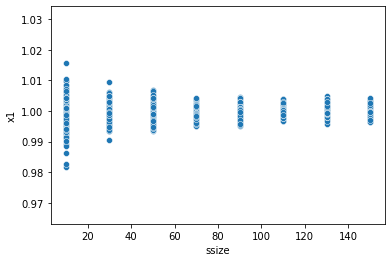

In [69]:
sns.scatterplot(x=meanratio_df['ssize'],y=meanratio_df['x1'],data=meanratio_df)

In [70]:
results_df.to_excel(r'C:/EMP Master Thesis/Monte Carlo_October21/complete_sample.xlsx', 
                    index=False, sheet_name='data')

Sample for testing the GAMS file 

In [249]:
nstart=10 #number of farms in the start sample
nmax=100 #number of farms in the biggest sample
stepsize=15 #increment by which number of farms increases in each step
nruns= 2 #number of runs for each stepsize
mu_b= 15 #mean size of farmland b
stdev_b=2.5  #standard deviation of farmland b
print(Q)

[[ 4.    2.    0.2 ]
 [ 2.   17.    0.5 ]
 [ 0.2   0.5   9.02]]


In [250]:
counter, ssize, run, landsize = [],[],[],[]
samplesize=nstart
farmcounter=0
while samplesize <= nmax:
    currentrun=0
    while currentrun < nruns:
        b_raw=np.random.normal(mu_b, stdev_b, samplesize)
        for i in b_raw: 
            counter.append(farmcounter)
            ssize.append(samplesize)
            run.append(currentrun)
            landsize.append(round(i, 2))
            farmcounter+=1
        currentrun+=1
    samplesize+=stepsize
randomsamples={'counter':counter,'samplesize':ssize, 'run':run,'landsize':landsize }

randomsamples_df=pd.DataFrame(randomsamples)


X0=[1,1,1,1,0,0,0,0]    #set initial values
bndx=(0.0, 1000000.0)
bndy=(0.0, 1000000.0)
bndz=(0.0, 1000000.0)
bnds=(bndx, bndx, bndx, bndy, bndz, bndz, bndz, bndz)
con1 = {'type': 'eq', 'fun':constraint1}
con2 = {'type': 'eq', 'fun':constraint2}
cons = [con1, con2]

results={"run":[],"samplesize":[],"fid":[],"x1":[],"x2":[],"x3":[],"y":[],"zp1":[],"zp2":[],"zp3":[],"zd1":[], "b":[]}
for f in range(len(randomsamples_df)):
    b_farm=float(randomsamples_df[randomsamples_df['counter']==f]['landsize'])
    sol= minimize(objective, X0, method='SLSQP',\
                 bounds=bnds, constraints=cons)
    results["run"].append(int(randomsamples_df[randomsamples_df['counter']==f]['run']))
    results["samplesize"].append(int(randomsamples_df[randomsamples_df['counter']==f]['samplesize']))
    results["fid"].append(f)
    results["x1"].append(sol.x[0])
    results["x2"].append(sol.x[1])
    results["x3"].append(sol.x[2])
    results["y"].append(sol.x[3])
    results["zp1"].append(sol.x[4])
    results["zp2"].append(sol.x[5])
    results["zp3"].append(sol.x[6])
    results["zd1"].append(sol.x[7])
    results["b"].append(b_farm)

results_df=pd.DataFrame(results)

In [251]:
"""
Add deviation from activity levels x and from fixed input prices y:
-the difference between "true" activity levels and observed activity levels is h:
    -h1 = x1 - x1_obs
    -h2 = x2 - x2_obs
    -h3 = x3 - x3_obs
-the difference between "true" fixed input prices and observed fixed input prices:
    -u  =  y - y_obs
    
Error terms h and u are randomly drawn from a standard normal distribution
"""
mu_h, mu_u = 0, 0 #mean of error term h and u, respectively
stdev_h, stdev_u = 0, 0 #standard deviation of error term h and u, respectively
h={'h1':[], 'h2':[], 'h3':[]}
#should error level depend on mean of the levels of the respective activity?
#if yes, stdev_h is multiplied by the ratio of the mean of the respective activity and 
#the mean of the activity that has the biggest mean
weight_on=True #weight stdev, otherwise set to False
activity_means=[]
for i in h.keys(): activity_means.append(float(results_df[f'x{i[1]}'].mean()))
weight={'h1':1, 'h2':1, 'h3':1}
if weight_on:
    for i,j in enumerate(h.keys()): weight[j]=activity_means[i]/max(activity_means)               
                                                   
for i in h.keys():
    h[i]=list(np.random.normal(mu_h, stdev_h*weight[i], len(results_df)))
u={'u':[]}
for j in u.keys():
    u[j]=list(np.random.normal(mu_u, stdev_u, len(results_df)))
h['fid']=list(range(len(results_df)))
u['fid']=list(range(len(results_df)))
df_h=pd.DataFrame(h)
df_u=pd.DataFrame(u)

In [252]:
results_df=pd.merge(pd.merge(results_df, df_h, on='fid'),df_u, on='fid')
results_df['x1_obs']=results_df.apply(lambda x: create_obs(x.x1, x.h1), axis=1)
results_df['x2_obs']=results_df.apply(lambda x: create_obs(x.x2, x.h2), axis=1)
results_df['x3_obs']=results_df.apply(lambda x: create_obs(x.x3, x.h3), axis=1)
results_df['y_obs']=results_df.apply(lambda x: create_obs(x.y, x.u), axis=1)
results_df['p1']=p[0]
results_df['p2']=p[1]
results_df['p3']=p[2]

In [253]:
results_df.head()

,run,samplesize,fid,x1,x2,x3,y,zp1,zp2,zp3,...,h2,h3,u,x1_obs,x2_obs,x3_obs,y_obs,p1,p2,p3
0,0,10,0,8.233065,2.911269,4.325666,17.880004,2.470845e-14,1.272236e-13,0.000000e+00,...,0.0,0.0,0.0,8.233065,2.911269,4.325666,17.880004,59,91,62
1,0,10,1,7.801738,2.857564,4.130698,19.751980,0.000000e+00,2.450312e-13,1.188786e-12,...,0.0,0.0,0.0,7.801738,2.857564,4.130698,19.751980,59,91,62
2,0,10,2,8.689822,2.968013,4.532166,15.898584,0.000000e+00,3.898276e-14,0.000000e+00,...,0.0,0.0,0.0,8.689822,2.968013,4.532166,15.898584,59,91,62
3,0,10,3,5.422612,2.561897,3.055491,30.074577,0.000000e+00,0.000000e+00,2.169736e-12,...,0.0,0.0,0.0,5.422612,2.561897,3.055491,30.074577,59,91,62
4,0,10,4,6.704182,2.721210,3.634607,24.514222,1.515060e-15,4.754682e-15,5.369144e-15,...,0.0,0.0,0.0,6.704182,2.721210,3.634607,24.514222,59,91,62


In [256]:
results_df.to_excel(r'C:/EMP Master Thesis/Monte Carlo_October21/TEST_complete_sample.xlsx', 
                    index=False, sheet_name='data')

In [160]:
results_df[results_df['y']==0]

,run,samplesize,fid,x1,x2,x3,y,zp1,zp2,zp3,...,h2,h3,u,x1_obs,x2_obs,x3_obs,y_obs,p1,p2,p3


In [254]:
testfarm=results_df[results_df['fid']==1]
float(testfarm['y'])+c[1]+Q[1][0]*float(testfarm['x1'])+Q[1][1]*float(testfarm['x2'])+Q[1][2]*float(testfarm['x3'])


90.99939784569284

In [257]:
gamsq=np.array([[2.78,2.74,2.69],[2.74,2.78,2.76],[2.69,2.76,2.9]])  #85.1
gamsc=np.array([-1.41,30.48,1.43])

In [258]:
for f in range(len(results_df)):
    testfarm=results_df[results_df['fid']==f]
    for i in range(nofactivities):
        print(float(testfarm['y'])+gamsc[i]+gamsq[i][0]*float(testfarm['x1'])+gamsq[i][1]*float(testfarm['x2'])+gamsq[i][2]*float(testfarm['x3']))


58.97084334259179
90.95076809310261
62.03648264918544
58.97211492362228
90.95349685600327
62.03455641855362
58.97016823820755
90.94854747048436
62.03919932908835
58.97830741715846
90.96776318052801
62.02316336633139
58.975059342120545
90.96016300191623
62.0293747346349
58.97144577796947
90.95198047472357
62.03569489322558
58.972808670898864
90.95487450186509
62.03373424832168
58.9731204786972
90.95589244792205
62.03248847764724
58.97123108235206
90.95069956040024
62.03785112045236
58.96322360604073
90.93297425782487
62.05107508631481
58.96884818330516
90.94649717523757
62.03948065386404
58.97170624674732
90.95274486010041
62.034899172428766
58.96683640099622
90.94097148440491
62.04509782947788
58.96539095373158
90.93795280314905
62.047068300519875
58.9730101843787
90.95610168337936
62.03176699563617
58.975553770042715
90.96143326948129
62.02818139485029
58.963751326146074
90.93477521968593
62.04884034023105
58.972987647236124
90.95563134097094
62.03263958158138
58.96884818330516
90.946

58.96855287600799
90.94477154801824
62.04225790729634
58.97463559092546
90.9589193449054
62.03073235109475
58.97885147036081
90.96963416929404
62.02077956669251
58.97382991368474
90.95758438687805
62.03111578173725
58.97592753821925
90.96234526292359
62.02738159804589
58.9678071995189
90.9440696443918
62.04141839945249
58.969922734502866
90.94889091650009
62.03770417574676
58.96539824393063
90.93827268012623
62.04645467769807
58.9678071995189
90.9440696443918
62.04141839945249
58.971754270903745
90.95259387978179
62.03535118030527
58.972401923664506
90.9543326819776
62.033691458049205
58.97330061434871
90.95657100626474
62.03159904000208
58.96559199142963
90.93930890744298
62.04482015575036
58.969753952521586
90.9487001728834
62.03758316444105
58.97615123416797
90.9628046988763
62.0270880312591
58.97295118566556
90.9549960125151
62.0339239145394
58.97828091393497
90.96752125828364
62.02360030563585
58.96050770810829
90.92645782808101
62.056635991109204
58.97662349465774
90.963785553688

62.035006976403835
58.966281074197724
90.94037504034691
62.04464469235504
58.97211492362228
90.95349685600327
62.03455641855362
58.9746752663586
90.95889301928483
62.03090983166105
58.96922832156488
90.94739318347776
62.03873200965626
58.96539824393063
90.93827268012623
62.04645467769807
58.96525362333401
90.9379596640278
62.046688278657115
58.973073692689695
90.95600401057082
62.03213021209993
58.97527239686677
90.96076439958857
62.02874283394493
58.97315606124827
90.95615019749347
62.032067298685085
58.9737743227586
90.95715464181899
62.03183765773878
58.96852258576834
90.94574507333475
62.040096434534995
58.977238683743856
90.9656528243008
62.02432556029575
58.97173023495142
90.95283242645097
62.0347803196477
58.97127998188444
90.95153135312329
62.03622705256505
58.966167101191445
90.9405309913705
62.04399171373392
58.96539512477675
90.93885316467467
62.04518468432252
58.970505000464
90.94925556287158
62.0386516302238
58.97306004049243
90.95618893388121
62.031709380568515
58.9685217

In [266]:
print(random.randint(-9,9))

-5


bias for testing of fixed effect

In [5]:
results_df=pd.read_excel('samples before error.xlsx')

In [6]:
results_df

,run,samplesize,fid,x1,x2,x3,y,zp1,zp2,zp3,zd1,b,p1,p2,p3
0,0,10,0,59.276985,13.634485,38.458530,66.431357,0.000000e+00,0.000000e+00,0.000000e+00,3.275304e-13,111.37,340,441,434
1,0,10,1,67.393817,14.090566,39.765617,15.789844,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,121.25,323,415,397
2,0,10,2,70.378158,13.489776,39.702066,40.066613,2.711742e-11,6.159569e-12,1.673472e-11,0.000000e+00,123.57,358,435,421
3,0,10,3,45.607083,12.333110,29.059806,141.592821,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,87.00,356,462,421
4,0,10,4,67.648770,11.471389,39.089841,53.143829,0.000000e+00,0.000000e+00,0.000000e+00,3.042642e-13,118.21,356,408,427
5,0,10,5,47.956084,14.869195,34.584721,91.019899,5.433385e-12,8.549133e-13,7.037620e-12,4.297097e-13,97.41,321,462,422
6,0,10,6,47.501235,9.627976,33.610789,100.516344,1.615183e-11,2.787332e-12,1.809399e-11,5.910934e-12,90.74,318,381,420
7,0,10,7,58.102752,11.307270,36.989979,52.075801,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,106.40,316,384,405
8,0,10,8,35.807841,13.273687,26.698472,130.381766,0.000000e+00,0.000000e+00,1.289726e-12,0.000000e+00,75.78,307,446,387
9,0,10,9,46.182696,13.948540,28.788764,91.114921,0.000000e+00,4.191707e-12,3.037612e-12,8.906673e-13,88.92,311,440,369


In [ ]:
mu_h, mu_u = 0, 0 #mean of error term h and u, respectively
stdev_h, stdev_u = 1., 1. #standard deviation of error term h and u, respectively
h={'h1':[], 'h2':[], 'h3':[]}
#should error level depend on mean of the levels of the respective activity?
#if yes, stdev_h is multiplied by the ratio of the mean of the respective activity and 
#the mean of the activity that has the biggest mean
weight_on=True #weight stdev, otherwise set to False
activity_means=[]
for i in h.keys(): activity_means.append(float(results_df[f'x{i[1]}'].mean()))
weight={'h1':1, 'h2':1, 'h3':1}
if weight_on:
    for i,j in enumerate(h.keys()): weight[j]=activity_means[i]/max(activity_means)               
                                                   
for i in h.keys():
    h[i]=list(np.random.normal(mu_h, stdev_h*weight[i], len(results_df)))
u={'u':[]}
for j in u.keys():
    u[j]=list(np.random.normal(mu_u, stdev_u, len(results_df)))
h['fid']=list(range(len(results_df)))
u['fid']=list(range(len(results_df)))
df_h=pd.DataFrame(h)
df_u=pd.DataFrame(u)